# MOM6 ANALYSIS - EAC Mooring Transports
Here we will compare the mooring transports from the EAC mooring (Sloyan et al., 2023) with the transports from the models for the same region.

We're interested in both the mean and range of variability for the transports of the EAC jet.

This notebook will also be used to look at mean- and eddy-kinetic energy (EKE) slices with depth both up and downstream of the separation region to understand how these change. We define EKE as the perturbation or residual after subtracting the MKE. 

### 1. Load in data and subset in space around the EAC MOORING SITE

In [1]:
import matplotlib.pyplot as plt
import cmocean as cm
import xarray as xr
import numpy as np
import glob
import xesmf

In [2]:
from matplotlib import patches
import cartopy.feature as cfeature
import matplotlib.lines as mlines
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [3]:
from xgcm import Grid

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [4]:
# import cartopy to plot maps
import cartopy.crs as ccrs
import cartopy.feature as feature
land_50m = feature.NaturalEarthFeature('physical', 'land', '50m', 
                                       edgecolor='black',
                                       facecolor='gray',
                                       linewidth=0.2)

In [5]:
client = Client()
client

<Client: 'tcp://127.0.0.1:42681' processes=7 threads=14, memory=63.00 GiB>

## Contents
### 1. Set paths, choose variables, open datasets
### 2. Preprocessing - subsetting, re-gridding etc.

## Section 1 - Setup

In [6]:
# set paths to model output
## SRM
# eac_003 = '/scratch/v45/jr5971/mom6/archive/eac-003-latest/'
eac_003 = '/scratch/v45/jr5971/mom6-setonix/eac_iaf_003/'
## LRM
sthpac_01 = '/scratch/v45/jr5971/mom6-setonix/sthpac_iaf_01/'
## PARENT
access = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/'
## EAC MOORING 
eac_mooring = '/scratch/v45/jr5971/eac-mooring/'

Right, so we've got our paths to the model output. Now we want to start by getting velocities from each of the models.

In [7]:
import os
os.chdir('/home/581/jr5971/jr5971/notebooks/')
# from custom_funcs import *
from myfuncs import *

#### Load OM2 data

In [8]:
# get vars from access;
om2_iaf, _ = open_iaf_global(input_vars=['u','v'],
                             first_year=1990, last_year=2020,
                            decode_times=True)
om2_iaf

<xarray.Dataset>
Dimensions:         (xu_ocean: 3600, yu_ocean: 2700, st_ocean: 75,
                     st_edges_ocean: 76, time: 10957, nv: 2)
Coordinates:
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T...
  * nv              (nv) float64 1.0 2.0
Data variables:
    u               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(31, 75, 300, 300), meta=np.ndarray>
    average_T1      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_T2      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_DT      (time) timedelta64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    time_bnds       (time, nv) timedelta64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    v               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(31, 75, 300, 300), meta=np.ndarray>
Attributes:
    filename:   ocean-3d-u-1-daily-mean-ym_1990_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20221019T1337Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

**Note - this is the typical way of doing things, but for now we're just loading in the single velocity files from the new eac-003 run**

#### Load EAC data

In [9]:
eac_u_files = get_mom6_files(path=eac_003, years = 'all', input_vars=['u'])
eac_v_files = get_mom6_files(path=eac_003, years = 'all', input_vars=['v'])
eac_temp_files = get_mom6_files(path=eac_003, years='all', input_vars=['temp'])
# sort lists                               
eac_u_files.sort()
eac_v_files.sort()
eac_temp_files.sort()
# open files
# eac_u = xr.open_mfdataset(eac_u_files[-2:], parallel=True)
# eac_v = xr.open_mfdataset(eac_v_files)
# eac_temp = xr.open_mfdataset(eac_temp_files)

In [9]:
# lon range and lat for EAC MOORING
eac_mooring = {'lon':[153.771-360, 155.30-360], 'lat':-27.3}
# extend longitude to the coast for model output
eac_mooring_ext = {'W':eac_mooring['lon'][0]-2, 'E':eac_mooring['lon'][1]+0.5, 
                   'lat':eac_mooring['lat']}
eac_mooring_ext

{'W': -208.229, 'E': -204.2, 'lat': -27.3}

In [10]:
mooring_box = {'W':eac_mooring_ext['W'], 'E':eac_mooring_ext['E'],
               'S':eac_mooring_ext['lat']-0.05, 'N':eac_mooring_ext['lat']+0.05}
mooring_box

{'W': -208.229, 'E': -204.2, 'S': -27.35, 'N': -27.25}

In [11]:
def open_mom6_and_slice(file_ls, var='u', bounds=mooring_box):
    if var in ['uo', 'vo']:
        try:
            da_full_ls = [xr.open_dataset(file)[var] for file in file_ls]
            print(len(da_full_ls))
            da_sliced_ls = [da.sel(yh=slice(bounds['S'], bounds['N']), xq=slice(bounds['W'], bounds['E'])) for da in da_full_ls]
            da_slice_combined = xr.concat(da_sliced_ls, dim='time')
        except:
            da_full_ls = [xr.open_dataset(file)[var] for file in file_ls]
            print(len(da_full_ls))
            da_sliced_ls = [da.sel(yq=slice(bounds['S'], bounds['N']), xh=slice(bounds['W'], bounds['E'])) for da in da_full_ls]
            da_slice_combined = xr.concat(da_sliced_ls, dim='time')
    else:
        da_full_ls = [xr.open_dataset(file)[var] for file in file_ls]
        print(len(da_full_ls))
        da_sliced_ls = [da.sel(yh=slice(bounds['S'], bounds['N']), xh=slice(bounds['W'], bounds['E'])) for da in da_full_ls]
        da_slice_combined = xr.concat(da_sliced_ls, dim='time')
        
    return da_slice_combined

In [12]:
len(eac_temp_files)

39

In [13]:
%%time
eac_temp = open_mom6_and_slice(file_ls=eac_temp_files[:-2], var='thetao', bounds=mooring_box)
eac_temp

37
CPU times: user 12.8 s, sys: 15.4 s, total: 28.2 s
Wall time: 1min 41s


<xarray.DataArray 'thetao' (time: 1154, z_l: 100, yh: 4, xh: 121)>
array([[[[      nan,       nan,       nan, ..., 22.97806 , 22.979282,
          22.98034 ],
         [      nan,       nan,       nan, ..., 22.998102, 22.999031,
          23.001646],
         [      nan,       nan,       nan, ..., 23.015764, 23.017542,
          23.020905],
         [      nan,       nan,       nan, ..., 23.03638 , 23.035936,
          23.038513]],

        [[      nan,       nan,       nan, ..., 22.972637, 22.973883,
          22.974957],
         [      nan,       nan,       nan, ..., 22.992691, 22.993637,
          22.996254],
         [      nan,       nan,       nan, ..., 23.010326, 23.012129,
          23.015533],
         [      nan,       nan,       nan, ..., 23.030945, 23.030529,
          23.033127]],

        [[      nan,       nan,       nan, ..., 22.969624, 22.970875,
          22.971937],
...
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 -208.2 -208.2 -208.1 -208.1 ... -204.3 -204.2 -204.2
  * yh       (yh) float64 -27.35 -27.32 -27.29 -27.26
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 4.946e+03 5.134e+03 5.324e+03
  * time     (time) object 1990-02-02 12:00:00 ... 1993-03-31 12:00:00
Attributes:
    units:          degC
    long_name:      Sea Water Potential Temperature
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

In [17]:
eac_temp_subset2mooringlon = eac_temp.sel(xh=slice(eac_mooring['lon'][0], eac_mooring['lon'][1]))
eac_temp_subset2mooringlon

<xarray.DataArray 'thetao' (time: 1154, z_l: 100, yh: 4, xh: 46)>
array([[[[25.854134, 25.922129, 25.96932 , ..., 23.41788 , 23.371807,
          23.316992],
         [25.853313, 25.922417, 25.97205 , ..., 23.455074, 23.41356 ,
          23.3647  ],
         [25.850836, 25.92154 , 25.973906, ..., 23.485806, 23.451942,
          23.406593],
         [25.846523, 25.919458, 25.974688, ..., 23.51299 , 23.484915,
          23.447035]],

        [[25.857094, 25.925425, 25.973211, ..., 23.413166, 23.367031,
          23.312046],
         [25.856312, 25.925762, 25.975668, ..., 23.450426, 23.408783,
          23.359825],
         [25.853876, 25.924923, 25.977545, ..., 23.481108, 23.447237,
          23.401745],
         [25.849573, 25.92286 , 25.978357, ..., 23.508324, 23.480177,
          23.44223 ]],

        [[25.85859 , 25.927128, 25.975698, ..., 23.410625, 23.364428,
          23.309357],
...
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 -206.2 -206.2 -206.1 -206.1 ... -204.8 -204.7 -204.7
  * yh       (yh) float64 -27.35 -27.32 -27.29 -27.26
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 4.946e+03 5.134e+03 5.324e+03
  * time     (time) object 1990-02-02 12:00:00 ... 1993-03-31 12:00:00
Attributes:
    units:          degC
    long_name:      Sea Water Potential Temperature
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

In [ ]:
eac_u = open_mom6_and_slice(file_ls = eac_u_files, var='uo', bounds=mooring_box)
eac_u

In [18]:
%%time
eac_v = open_mom6_and_slice(file_ls=eac_v_files[:-2], var='vo', bounds=mooring_box)
eac_v

37
37
CPU times: user 32.2 s, sys: 37 s, total: 1min 9s
Wall time: 5min 12s


<xarray.DataArray 'vo' (time: 1154, z_l: 100, yq: 3, xh: 121)>
array([[[[        nan,         nan,         nan, ..., -0.26455426,
          -0.26410913, -0.26349255],
         [        nan,         nan,         nan, ..., -0.25728232,
          -0.2580954 , -0.25792468],
         [        nan,         nan,         nan, ..., -0.24994527,
          -0.25103852, -0.2516115 ]],

        [[        nan,         nan,         nan, ..., -0.23264222,
          -0.23198436, -0.23113918],
         [        nan,         nan,         nan, ..., -0.22514829,
          -0.22572602, -0.22535025],
         [        nan,         nan,         nan, ..., -0.21759546,
          -0.21844457, -0.21883881]],

        [[        nan,         nan,         nan, ..., -0.21608092,
          -0.21531348, -0.21436943],
         [        nan,         nan,         nan, ..., -0.20847711,
          -0.20895027, -0.20847574],
         [        nan,         nan,         nan, ..., -0.20080796,
          -0.2015637 , -0.20185784]],
...
        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 -208.2 -208.2 -208.1 -208.1 ... -204.3 -204.2 -204.2
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 4.946e+03 5.134e+03 5.324e+03
  * time     (time) object 1990-02-02 12:00:00 ... 1993-03-31 12:00:00
  * yq       (yq) float64 -27.33 -27.3 -27.27
Attributes:
    units:          m s-1
    long_name:      Sea Water Y Velocity
    cell_methods:   z_l:mean yq:point xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_y_velocity
    interp_method:  none

### Calculating transports
$$
T_y = vo * dxCv * dz
$$

In [21]:
# get grid cell thickness data
eac_static = xr.open_dataset('/home/581/jr5971/scratch/mom6/archive/eac-003-latest/output000/19900202.ocean_static.nc')

In [38]:
# take average of the few grid cells in the meridional direction
eac_v_mooring = eac_v.mean('yq').sel(xh=slice(eac_mooring['lon'][0], eac_mooring['lon'][1]))
dx = eac_static['dxCv'].sel(xh = slice(eac_mooring['lon'][0], eac_mooring['lon'][1])).sel(yq=eac_mooring['lat'], method='nearest')
dz = np.gradient(eac_v_mooring.z_l)[np.newaxis,:,  np.newaxis]
eac_v_mooring

<xarray.DataArray 'vo' (time: 1154, z_l: 100, xh: 46)>
array([[[-0.66790146, -0.76990634, -0.8535076 , ..., -0.28581908,
         -0.28590062, -0.28460667],
        [-0.6788817 , -0.7797444 , -0.8620538 , ..., -0.2590318 ,
         -0.2587168 , -0.2568867 ],
        [-0.6837833 , -0.78405064, -0.86574435, ..., -0.24474269,
         -0.24423252, -0.24217989],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.5832986 , -0.70768213, -0.81572986, ..., -0.11203465,
         -0.10921913, -0.10452794],
        [-0.5758657 , -0.7001068 , -0.80792326, ..., -0.08425427,
         -0.08133093, -0.07603634],
        [-0.5725673 , -0.6966915 , -0.8042547 , ..., -0.07003025,
         -0.06696657, -0.06148508],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.9278831 , -0.88861066, -0.85512847, ...,  0.16290708,
          0.15211058,  0.15095896],
        [-0.94362783, -0.9039425 , -0.87094325, ...,  0.14205444,
          0.13101727,  0.12962127],
        [-0.951415  , -0.91196537, -0.87905806, ...,  0.13106391,
          0.1199953 ,  0.11846483],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 -206.2 -206.2 -206.1 -206.1 ... -204.8 -204.7 -204.7
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 4.946e+03 5.134e+03 5.324e+03
  * time     (time) object 1990-02-02 12:00:00 ... 1993-03-31 12:00:00

In [42]:
# Choose surface 1000m to take transports over
T_mooring = (eac_v_mooring * dz * dx) * 1e-6
T_mooring

<xarray.DataArray (time: 1154, z_l: 100, xh: 46)>
array([[[-1.33548192e-03, -1.53944267e-03, -1.70660497e-03, ...,
         -5.71500805e-04, -5.71663844e-04, -5.69076551e-04],
        [-1.40727503e-03, -1.61635643e-03, -1.78697820e-03, ...,
         -5.36955091e-04, -5.36302096e-04, -5.32508423e-04],
        [-1.52151703e-03, -1.74462643e-03, -1.92640678e-03, ...,
         -5.44587995e-04, -5.43452790e-04, -5.38885380e-04],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-1.16631692e-03, -1.41502416e-03, -1.63106768e-03, ...,
         -2.24015454e-04, -2.18385763e-04, -2.09005650e-04],
        [-1.19372992e-03, -1.45127319e-03, -1.67476928e-03, ...,
         -1.74653305e-04, -1.68593408e-04, -1.57618101e-04],
        [-1.27404527e-03, -1.55023969e-03, -1.78958341e-03, ...,
         -1.55827465e-04, -1.49010335e-04, -1.36813227e-04],
...
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-1.85532024e-03, -1.77679426e-03, -1.70984597e-03, ...,
          3.25735866e-04,  3.04148050e-04,  3.01845361e-04],
        [-1.95607553e-03, -1.87381062e-03, -1.80540539e-03, ...,
          2.94469070e-04,  2.71589775e-04,  2.68695962e-04],
        [-2.11703641e-03, -2.02925525e-03, -1.95603172e-03, ...,
          2.91636210e-04,  2.67006942e-04,  2.63601428e-04],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * xh       (xh) float64 -206.2 -206.2 -206.1 -206.1 ... -204.8 -204.7 -204.7
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 4.946e+03 5.134e+03 5.324e+03
  * time     (time) object 1990-02-02 12:00:00 ... 1993-03-31 12:00:00
    yq       float64 -27.3

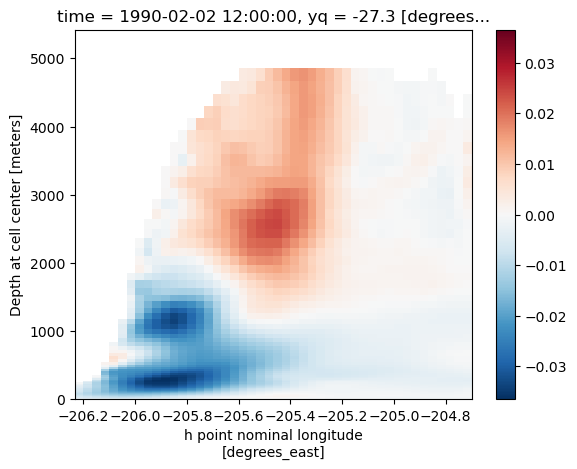

In [43]:
T_mooring.isel(time=0).plot()

In [46]:
# take the sum of the top 2000 m
T_top2000 = T_mooring.sel(z_l=slice(0,2000)).sum('z_l').sum('xh')
T_top2000

<xarray.DataArray (time: 1154)>
array([-20.86197698, -21.1069612 , -21.65849116, ...,  -7.2916249 ,
        -6.42661858,  -5.04949956])
Coordinates:
  * time     (time) object 1990-02-02 12:00:00 ... 1993-03-31 12:00:00
    yq       float64 -27.3

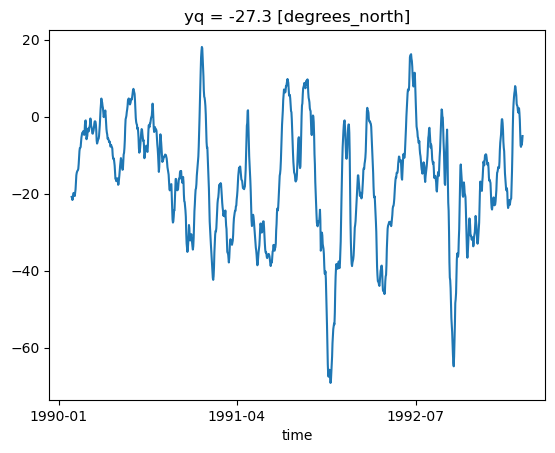

In [47]:
T_top2000.plot()

In [67]:
import seaborn as sns

(-75.0, 25.0)

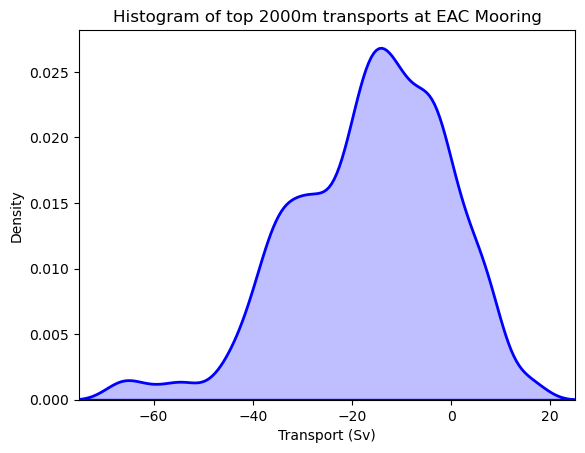

In [88]:
# plt.hist(T_top2000, color='blue', edgecolor='k', 
#          bins = int(180/5))
# seaborn histogram
sns.distplot(T_top2000, hist=False, kde=True,
             bins=int(180/5),
             color='blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth':2, 'bw':.2, 'shade':True})


# Add labels
plt.title('Histogram of top 2000m transports at EAC Mooring')
plt.xlabel('Transport (Sv)')
plt.ylabel('Density')
plt.xlim(-75, 25)

In [56]:
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

In [59]:
yf = np.fft.rfft(T_top2000)

In [62]:
xf = np.fft.rfftfreq(len(T_top2000), 1)

(0.0, 0.1)

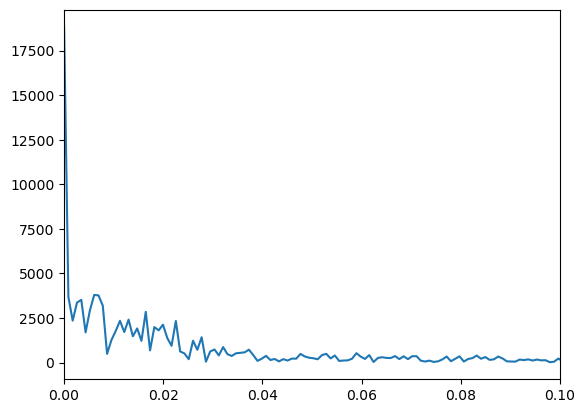

In [66]:
plt.plot(xf, np.abs(yf))
plt.xlim(0,0.1)

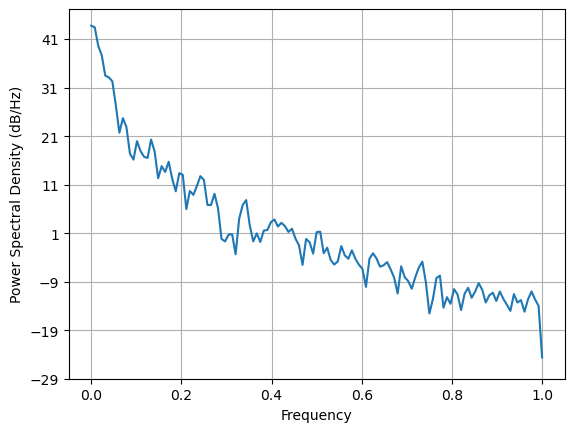

In [58]:
plt.psd(T_top2000);

In [48]:
from scipy import signal

In [53]:
freq, power = signal.periodogram(T_top2000, fs=1.0)

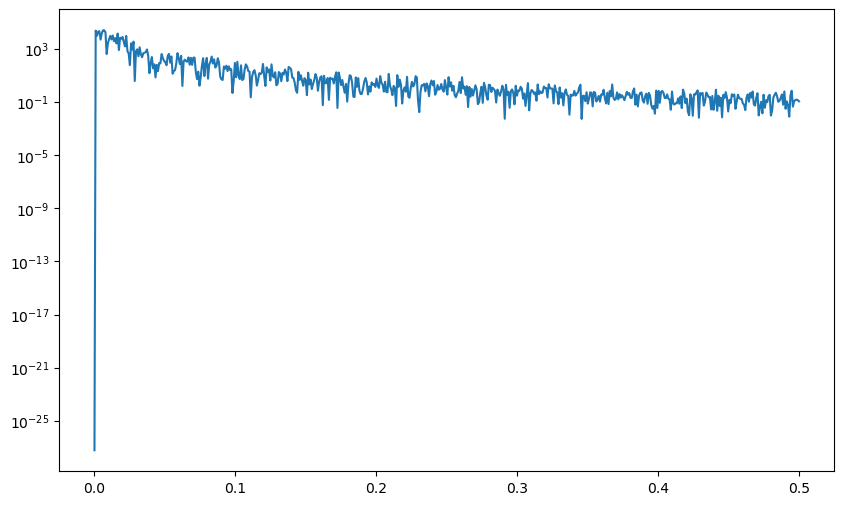

In [54]:
plt.figure(figsize=(10,6))
plt.semilogy(freq, power)

In [35]:
eac_v_mooring

<xarray.DataArray 'vo' (time: 1154, z_l: 100, xh: 121)>
array([[[        nan,         nan,         nan, ..., -0.25726062,
         -0.25774768, -0.25767624],
        [        nan,         nan,         nan, ..., -0.22512865,
         -0.225385  , -0.22510941],
        [        nan,         nan,         nan, ..., -0.20845532,
         -0.20860915, -0.20823435],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -0.07842422,
         -0.07794024, -0.07813173],
        [        nan,         nan,         nan, ..., -0.04815152,
         -0.04759021, -0.04771418],
        [        nan,         nan,         nan, ..., -0.03235725,
         -0.03177975, -0.03182982],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  0.5232877 ,
          0.57968134,  0.6365532 ],
        [        nan,         nan,         nan, ...,  0.5024402 ,
          0.55877167,  0.6155832 ],
        [        nan,         nan,         nan, ...,  0.4916198 ,
          0.5479633 ,  0.6047726 ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 -208.2 -208.2 -208.1 -208.1 ... -204.3 -204.2 -204.2
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 4.946e+03 5.134e+03 5.324e+03
  * time     (time) object 1990-02-02 12:00:00 ... 1993-03-31 12:00:00

In [34]:
dx

<xarray.DataArray 'dxCv' (xh: 46)>
[46 values with dtype=float32]
Coordinates:
  * xh       (xh) float64 -206.2 -206.2 -206.1 -206.1 ... -204.8 -204.7 -204.7
    yq       float64 -27.3
Attributes:
    units:          m
    long_name:      Delta(x) at v points (meter)
    cell_methods:   time: point
    interp_method:  none

In [29]:
eac = xr.merge([eac_u, eac_v])
eac

<xarray.Dataset>
Dimensions:  (yh: 203, z_l: 100, time: 667, xq: 0, xh: 0, yq: 203)
Coordinates:
  * yh       (yh) float64 -30.3 -30.27 -30.24 -30.21 ... -24.38 -24.35 -24.32
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 4.946e+03 5.134e+03 5.324e+03
  * time     (time) object 1990-02-02 12:00:00 ... 1991-11-30 12:00:00
  * xq       (xq) float64 
  * xh       (xh) float64 
  * yq       (yq) float64 -30.28 -30.25 -30.23 -30.2 ... -24.36 -24.33 -24.3
Data variables:
    uo       (time, z_l, yh, xq) float32 
    vo       (time, z_l, yq, xh) float32 
Attributes:
    units:          m s-1
    long_name:      Sea Water X Velocity
    cell_methods:   z_l:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

#### Load STHPAC data

In [11]:
sthpac_u_files = get_mom6_files(path=sthpac_01, years=[1992,1993],
                                input_vars=['u'])
sthpac_u = xr.open_mfdataset(sthpac_u_files)

In [12]:
sthpac_v_files = get_mom6_files(path=sthpac_01, years=[1992,1993],
                                input_vars=['v'])
sthpac_v = xr.open_mfdataset(sthpac_v_files)

In [13]:
sthpac_u_da = sthpac_u['uo']
sthpac_v_da = sthpac_v['vo']
sthpac = xr.merge([sthpac_u_da, sthpac_v_da])

### Mooring DATA

In [14]:
import zipfile

In [15]:
# with zipfile.ZipFile(glob.glob(eac_mooring+'*.zip')[0], 'r') as zip_ref:
#     zip_ref.extractall(eac_mooring)

In [16]:
mooring = xr.open_dataset(glob.glob(eac_mooring+'*.nc')[0])
mooring = mooring.rename({'TIME':'time','DEPTH':'depth', 'LONGITUDE':'lon'})
mooring

<xarray.Dataset>
Dimensions:   (time: 3770, depth: 271, lon: 124)
Coordinates:
  * time      (time) datetime64[ns] 2012-04-01T12:00:00 ... 2022-07-27T12:00:00
  * depth     (depth) float64 0.0 10.0 20.0 30.0 ... 4.96e+03 4.98e+03 5e+03
  * lon       (lon) float64 153.6 153.6 153.6 153.6 ... 155.2 155.3 155.3 155.3
    LATITUDE  (lon) float64 ...
Data variables:
    TEMP      (time, depth, lon) float64 ...
    PSAL      (time, depth, lon) float64 ...
    UCUR      (time, depth, lon) float64 ...
    VCUR      (time, depth, lon) float64 ...
Attributes: (12/38)
    project:                       Integrated Marine Observing System (IMOS),...
    Conventions:                   CF-1.6,IMOS-1.4
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         East Australian Current gridded (depth, di...
    date_created:                  2023-08-07T11:36:12Z
    date_modified:                 2023-08-07T11:36:12Z
    ...                            ...
    citation:                      The citation in a list of references is: "...
    persistent_URL:                https://hdl.handle.net/102.100.100/434305
    acknowledgement:               This project is supported with funding fro...
    disclaimer:                    Data, products and services from CSIRO are...
    license:                       http://creativecommons.org/licenses/by/4.0/
    comment:                       Data from the IMOS North Stradbroke Island...

(2000.0, 0.0)

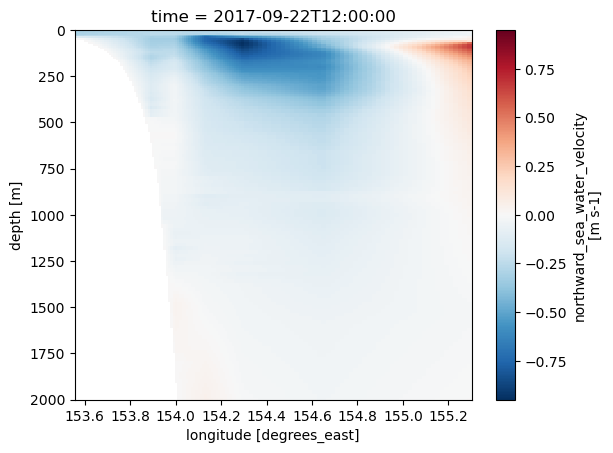

In [17]:
mooring.isel(time=2000)['VCUR'].plot()
plt.gca().invert_yaxis()
plt.ylim(2000,0)

How bout an animation showing the 

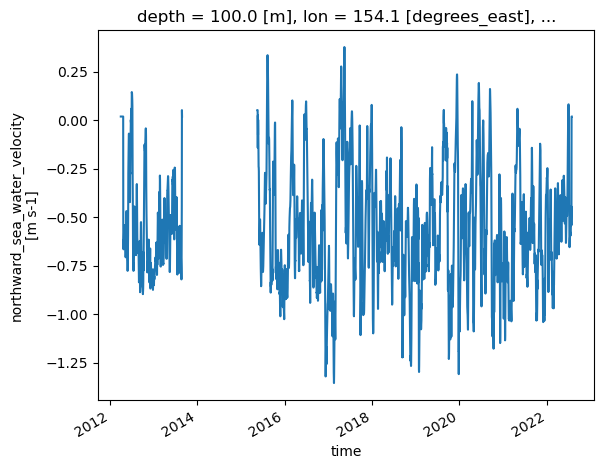

In [18]:
mooring['VCUR'].isel(lon=50, depth=10).plot()

In [19]:
# mooring coordinates
lon_mooring = [153.771-360, 155.30-360]
lat_mooring = [-27.3]

So, we have this dataset that has meridional and zonal velocities, as well as temperature and salinity. It ranges from 2012 to 2022, with a gap between late 2013, and late 2015. 

What could we do with this dataset? Calculate transports? Create PDF of transports? But then how do I divide the gridded data up? 

### Choose spatial and temporal extent
In order to make the regridding quicker later on, let's choose a temporal extent now. 

**Because we are just using the single month from eac-003, we need to select dates from the other models from within that time period**

In [20]:
daterange = [eac.time.min().values.astype(str).item(), eac.time.max().values.astype(str).item()]
daterange

['1992-10-01 12:00:00', '1992-10-31 12:00:00']

### Make Grids Symmetric

In [21]:
# EAC
# bottom corner "centre" coord
print('Bottom left centre points: ', np.round(eac.xh.min().values, 2), np.round(eac.yh.min().values,2))
# bottom left "corner" coord...
print('Bottom left CORNER points: ', np.round(eac.xq.min().values, 2), np.round(eac.yq.min().values,2))

Bottom left centre points:  -217.78 -46.18
Bottom left CORNER points:  -217.8 -46.19


In [22]:
# CREATE SYMMETRIC DATASETS
eac_symmetric = eac.isel(xq=slice(1,len(eac.xq)), yq = slice(1,len(eac.yq)))
sthpac_symmetric = sthpac.isel(xq=slice(1,len(sthpac.xq)), yq=slice(1,len(sthpac.yq)))

In [23]:
# EAC
# bottom corner "centre" coord
print('Bottom left centre points: ', np.round(eac_symmetric.xh.min().values, 2), np.round(eac_symmetric.yh.min().values,2))
# bottom left "corner" coord...
print('Bottom left CORNER points: ', np.round(eac_symmetric.xq.min().values, 2), np.round(eac_symmetric.yq.min().values,2))

Bottom left centre points:  -217.78 -46.18
Bottom left CORNER points:  -217.77 -46.17


In [24]:
# get grid cell thickness data
eac_static = xr.open_dataset('/home/581/jr5971/scratch/mom6/archive/eac-003-latest/19900401.ocean_static.nc')
sthpac_static = xr.open_dataset('/home/581/jr5971/scratch/mom6/archive/southpac-01/output000/19900101.ocean_static.nc')

eac_symmetric['dxt'] = eac_static['dxt']
eac_symmetric['dyt'] = eac_static['dyt']
sthpac_symmetric['dxt'] = sthpac_static['dxt']
sthpac_symmetric['dyt'] = sthpac_static['dyt']


# Define new aligned grids
metrics = { 
    ('X',) : ['dxt'], # X distances
    ('Y',) : ['dyt'] # Y  distances
}
coords = {'X' : {'center':'xh', 'right':'xq'},
          'Y' : {'center':'yh', 'right':'yq'} }

eac_grid = Grid(eac_symmetric, coords=coords, metrics=metrics, periodic=False)
sthpac_grid = Grid(sthpac_symmetric, coords=coords, metrics=metrics, periodic=False)
eac_grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   xh --> right
  * right    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> right
  * right    yq --> center

Overwrite the meridional velocities (`vo`) in the symmetric datasets with the new offset points

In [25]:
%%time
eac_symmetric['vo'] = eac_grid.interp(eac_symmetric['vo'], axis=['X','Y'])
sthpac_symmetric['vo'] = sthpac_grid.interp(sthpac_symmetric['vo'], axis=['X','Y'])
print(eac_symmetric['vo'].dims, eac['vo'].dims)

('time', 'z_l', 'yh', 'xq') ('time', 'z_l', 'yq', 'xh')
CPU times: user 34.4 s, sys: 32 s, total: 1min 6s
Wall time: 1min 26s


**NOTE: Be mindful to use the `symmetric` datasets going forward, not the original ones**

Now, here is where we are going to subset down - at least to the STHPAC region. But we might as well subset down to the EAC region, then draw some transects that we wish to take depth slices of...

In [26]:
# subset global to some region just bigger than the sthpac model...
sthpac_idx = {'W':sthpac.xh.min().values, 'E':sthpac.xh.max().values, 
              'S':sthpac.yh.min().values, 'N':sthpac.yh.max().values}
eac_idx = {'W':eac.xh.min().values, 'E':eac.xh.max().values,
           'S':eac.yh.min().values, 'N':eac.yh.max().values}
om2_subset = om2_iaf.sel(xu_ocean=slice(eac_idx['W'] - 30, eac_idx['E']+50),
                                        yu_ocean = slice(eac_idx['S']-30, eac_idx['N']+30))

Now, let's just take a snapshot of the region, and draw some transects before taking depth slices...

* The EAC mooring is around 27.4 degrees S, and spans 155°17′35.52″ E to 153°33′42.84″ E. That will be one transect. 
* Smokey Cape sits around 30.9 degrees S so we'll run a transect off there as well.

In [27]:
smokey_cape = {'lon':153, 'lat':-30.9}
eac_mooring = {'lon':[153.771, 155.30], 'lat':-27.3}
maria = {'lon':148.1, 'lat':-42.5}

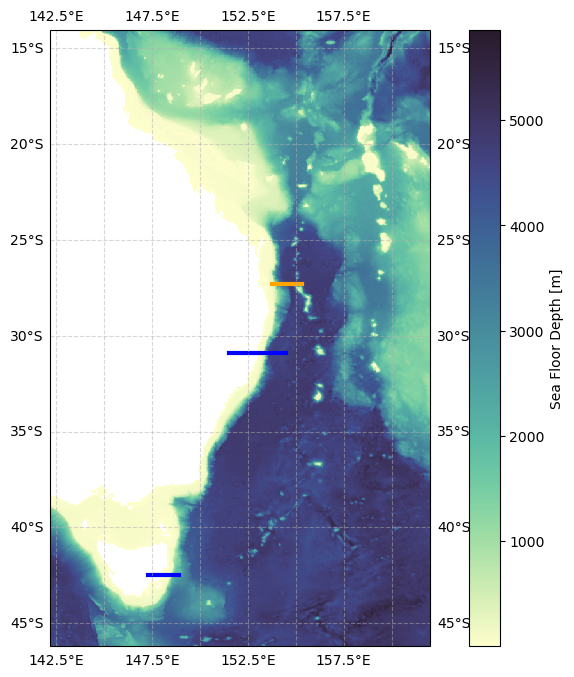

In [28]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
eac_static['deptho'].plot(ax=ax, cmap=cm.cm.deep, transform=ccrs.PlateCarree())

#Now draw transects
x11, x12 = eac_mooring['lon']
y1 = eac_mooring['lat']
l1 = mlines.Line2D([x11,x12], [y1,y1], linewidth=3, color='orange', transform=ccrs.PlateCarree())
ax.add_line(l1)

x21, x22 = [smokey_cape['lon']-1.5, smokey_cape['lon']+1.5]
y2 = smokey_cape['lat']
l2 = mlines.Line2D([x21,x22], [y2, y2], linewidth=3, color='blue', transform=ccrs.PlateCarree())
ax.add_line(l2)

x31, x32 = [maria['lon']-0.8, maria['lon']+0.8]
y3 = maria['lat']
l3 = mlines.Line2D([x31,x32], [y3, y3], linewidth=3, color='blue', transform=ccrs.PlateCarree())
ax.add_line(l3)

ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')


Right, let's go with these three transects for now. These can also be spots where we zoom in for higher resolution too. 

What's next? Let's zoom in on the EAC mooring array and get a better understanding of the topogrpahy and velocity in this region.

In [29]:
depth = 5 # metres
# select depth range from symmetric datasets and om2_subset
om2_2d = om2_subset.sel(st_ocean=depth, method='nearest')
eac_sym_2d = eac_symmetric.sel(z_l=depth, method='nearest')
sthpac_sym_2d = sthpac_symmetric.sel(z_l=depth, method='nearest')
sthpac_sym_2d

<xarray.Dataset>
Dimensions:  (yh: 705, time: 731, xq: 425, xh: 425, yq: 705)
Coordinates:
  * yh       (yh) float64 -49.96 -49.9 -49.83 -49.77 ... 12.16 12.26 12.35 12.45
    z_l      float64 4.332
  * time     (time) object 1992-01-01 12:00:00 ... 1993-12-31 12:00:00
  * xq       (xq) float64 -219.9 -219.8 -219.7 -219.6 ... -177.7 -177.6 -177.5
  * xh       (xh) float64 -219.9 -219.8 -219.7 -219.6 ... -177.7 -177.6 -177.5
  * yq       (yq) float64 -49.93 -49.87 -49.8 -49.74 ... 12.21 12.3 12.4 12.5
Data variables:
    uo       (time, yh, xq) float32 dask.array<chunksize=(31, 705, 425), meta=np.ndarray>
    vo       (time, yh, xq) float32 dask.array<chunksize=(31, 705, 425), meta=np.ndarray>
    dxt      (yh, xh) float32 ...
    dyt      (yh, xh) float32 ...
Attributes:
    units:          m s-1
    long_name:      Sea Water X Velocity
    cell_methods:   z_l:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

## Plotting
### 1. Plot snapshots of Speed 

In [30]:
%%time
# Choose single day to calculate speed for all variables. 
day = '1992-10-10'
om2_2d_snap = om2_2d.sel(time=day)
sthpac_2d_snap = sthpac_sym_2d.sel(time=day)
eac_2d_snap = eac_sym_2d.sel(time=day)

# Calculate snapshot of speed
om2_speed = np.sqrt(om2_2d_snap['v']**2 + om2_2d_snap['u']**2).compute()
print('om2 finished')
sthpac_speed = np.sqrt(sthpac_2d_snap['vo']**2 + sthpac_2d_snap['uo']**2).compute()
print('sthpac finished')
eac_speed = np.sqrt(eac_2d_snap['vo']**2 + eac_2d_snap['uo']**2).compute()

om2 finished
sthpac finished
CPU times: user 7.14 s, sys: 2.88 s, total: 10 s
Wall time: 51.9 s


So, I aim to start with the EAC mooring, but we could generalise it for any

In [31]:
eac_mooring

{'lon': [153.771, 155.3], 'lat': -27.3}

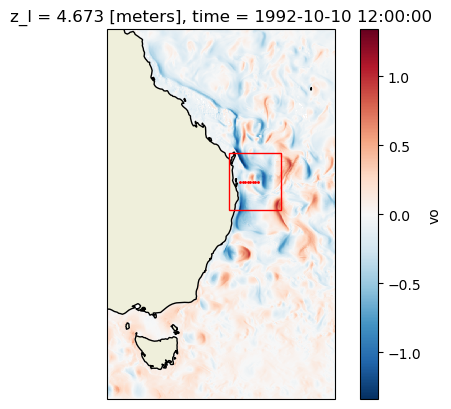

In [32]:
closeup = eac_mooring
x1 = closeup['lon'][0]
x2 = closeup['lon'][1]
y1 = closeup['lat']-0.5
y2 = closeup['lat']+0.5

if closeup == eac_mooring:
    array = np.linspace(x1, x2, 8)


ax = plt.axes(projection=ccrs.PlateCarree())
eac_2d_snap['vo'].plot(ax=ax)
ax.scatter(array, [eac_mooring['lat']]*len(array), color='red', marker='o', s=1)

b = 2 # set buffer
closeupBox = {'W':x1 - (b/2), 'E':x2 + b, 'S':y1 - b, 'N':y2 + b}
box_close = patches.Rectangle((closeupBox['W'], closeupBox['S']), (closeupBox['E']-closeupBox['W']),
                           (closeupBox['N']-closeupBox['S']), color='r', fill=None, zorder=3, transform=ccrs.PlateCarree())
ax.add_patch(box_close)
ax.add_feature(cfeature.LAND)
ax.coastlines()

In [33]:
array_shift = array - 360

In [37]:
eac_2d_snap_latlon = eac_2d_snap.rename({'xq':'lon', 'yh':'lat'})
x, y, u, v = regrid_for_streamplot(u=eac_2d_snap_latlon['uo'], v=eac_2d_snap_latlon['vo'], res=2)
u = u.squeeze()
v = v.squeeze()

In [38]:
eac_speed = eac_speed.squeeze()

In [39]:
# regrid speed to be plotted over the above...
eac_speed = eac_speed.rename({'yh':'lat', 'xq':'lon'})
x_t = np.linspace(eac_speed['lon'].min(), eac_speed['lon'].max(), 
                  int(len(eac_speed['lon'])/2))
y_t = np.linspace(eac_speed['lat'].min(), eac_speed['lat'].max(),
                  int(len(eac_speed['lat'])/2))
Xt, Yt = np.meshgrid(x_t, y_t)
regridder = xesmf.Regridder(eac_speed, {'lon':Xt, 'lat':Yt}, 'bilinear')
eac_speed_regridded = regridder(eac_speed)                      

Text(0.5, 0.98, 'EAC MOORING TRANSECT')

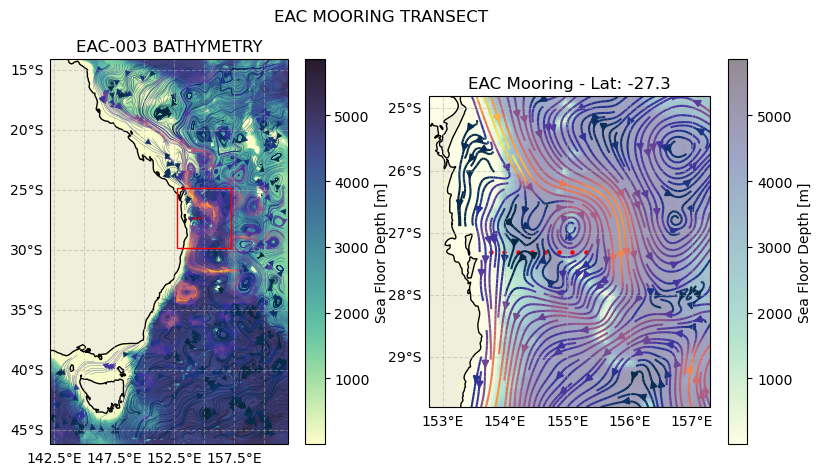

In [40]:
eac_depth = eac_static['deptho']
# closeup_depth = eac_depth.sel(xh=slice(closeupBox['W']-360, closeupBox['E']-360), yh=slice(closeupBox['S'], closeupBox['N']))

fig, axes = plt.subplots(1,2, figsize=(10,5), subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2)))
eac_depth.plot(ax=axes[0], cmap=cm.cm.deep, transform=ccrs.PlateCarree())
axes[0].add_feature(cfeature.LAND)
box_close = patches.Rectangle((closeupBox['W'], closeupBox['S']), (closeupBox['E']-closeupBox['W']),
                           (closeupBox['N']-closeupBox['S']), color='r', fill=None, zorder=3, transform=ccrs.PlateCarree())
axes[0].add_patch(box_close)
axes[0].scatter(array_shift, [eac_mooring['lat']]*len(array), color='red', marker='o', s=1, transform=ccrs.PlateCarree())
axes[0].streamplot(x, y, u, v, density=3, color=eac_speed_regridded.values, cmap=cm.cm.thermal, transform=ccrs.PlateCarree(),
                  linewidth=0.2, broken_streamlines=False)
axes[0].coastlines()
axes[0].set_title('EAC-003 BATHYMETRY')

closeup_extent = [closeupBox['W'], closeupBox['E'], closeupBox['S'], closeupBox['N']]
axes[1].set_extent(closeup_extent)
eac_depth.plot(ax=axes[1], cmap=cm.cm.deep, transform=ccrs.PlateCarree(), alpha=0.5)
axes[1].scatter(array_shift, [eac_mooring['lat']]*len(array), color='red', marker='o', s=5, transform=ccrs.PlateCarree())
axes[1].add_feature(cfeature.LAND)
axes[1].coastlines()
gl0 = axes[0].gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
gl1 = axes[1].gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
axes[1].streamplot(x, y, u, v, density=2, color=eac_speed_regridded.values, cmap=cm.cm.thermal, transform=ccrs.PlateCarree())
axes[1].set_title(f"EAC Mooring - Lat: {eac_mooring['lat']}")

for gl in [gl0, gl1]:
    gl.xlabels_top=False
    gl.ylabels_right=False


fig.suptitle('EAC MOORING TRANSECT')


**Add Streamlines to the above plot**

Make the color of the streamlines be temperature. This is for a later time though. For not I think that looks pretty awesome. 

### Depth Slices
Now we know the location of the transect, let's look at the depth slice. Perhaps plotting density from T/S as well.
- We don't have T/S right now, so we'll just work with velocities and introduce those later. 

- **NOTE** I'm going to plot the model output all the way to the coast, even though the mooring stops at the end of the shelf. 

In [41]:
eac_mooring

{'lon': [153.771, 155.3], 'lat': -27.3}

In [42]:
closeupBox['W'] = closeupBox['W']-360
closeupBox['E'] = closeupBox['E']-360

In [43]:
# select model output from the eac mooring latitude, and a buffer region around the mooring longitude range
# Note - also only looking in top 2000 m. 
maxdepth = 2000
var_om2 = 'v'
var_mom = 'vo'

om2_slice = om2_subset[var_om2].sel(yu_ocean=eac_mooring['lat'], method='nearest').sel(
    xu_ocean=slice(closeupBox['W'], closeupBox['E']), st_ocean=slice(0, maxdepth), time=slice(daterange[0], daterange[1]))
    
sthpac_slice = sthpac_symmetric[var_mom].sel(yh=eac_mooring['lat'], method='nearest').sel(
    xq=slice(closeupBox['W'], closeupBox['E']), z_l=slice(0,maxdepth), time=slice(daterange[0], daterange[1]))
eac_slice = eac_symmetric[var_mom].sel(yh=eac_mooring['lat'], method='nearest').sel(
    xq=slice(closeupBox['W'], closeupBox['E']), z_l=slice(0,maxdepth), time=slice(daterange[0], daterange[1]))
eac_slice

<xarray.DataArray 'vo' (time: 31, z_l: 79, xq: 135)>
array([[[            nan,             nan,             nan, ...,
          1.45527005e-01,  1.78959966e-01,  2.18107298e-01],
        [            nan,             nan,             nan, ...,
          1.21001795e-01,  1.54411316e-01,  1.93693936e-01],
        [            nan,             nan,             nan, ...,
          1.08507484e-01,  1.41966164e-01,  1.81307092e-01],
        ...,
        [            nan,             nan,             nan, ...,
         -2.71458970e-03, -4.32158448e-03, -4.52764519e-03],
        [            nan,             nan,             nan, ...,
          3.14094033e-03,  4.65932186e-04, -1.06982025e-03],
        [            nan,             nan,             nan, ...,
          9.39315464e-03,  6.26750570e-03,  3.65001755e-03]],

       [[            nan,             nan,             nan, ...,
          1.49408847e-01,  1.85165673e-01,  2.22654730e-01],
        [            nan,             nan,             nan, ...,
          1.24327004e-01,  1.60125718e-01,  1.97766140e-01],
        [            nan,             nan,             nan, ...,
          1.11505508e-01,  1.47428095e-01,  1.85159892e-01],
...
          2.42694877e-02,  3.03207878e-02,  3.70046236e-02],
        [            nan,             nan,             nan, ...,
          2.11829506e-02,  2.66518779e-02,  3.35570686e-02],
        [            nan,             nan,             nan, ...,
          1.53163541e-02,  2.17857324e-02,  3.05314194e-02]],

       [[            nan,             nan,             nan, ...,
         -7.03840554e-02, -8.53813514e-02, -9.07972604e-02],
        [            nan,             nan,             nan, ...,
         -6.34972602e-02, -7.85842091e-02, -8.40936452e-02],
        [            nan,             nan,             nan, ...,
         -5.94813339e-02, -7.46365488e-02, -8.02380443e-02],
        ...,
        [            nan,             nan,             nan, ...,
          2.29682457e-02,  2.91319899e-02,  3.61583382e-02],
        [            nan,             nan,             nan, ...,
          1.77805461e-02,  2.36184485e-02,  3.12489681e-02],
        [            nan,             nan,             nan, ...,
          1.07826032e-02,  1.78661533e-02,  2.74581052e-02]]],
      dtype=float32)
Coordinates:
    yh       float64 -27.29
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 1.688e+03 1.798e+03 1.913e+03
  * time     (time) object 1992-10-01 12:00:00 ... 1992-10-31 12:00:00
  * xq       (xq) float64 -207.2 -207.2 -207.1 -207.1 ... -202.8 -202.8 -202.7

In [46]:
%%time
# Plot average transport within depth slice
# om2-average
om2_v_mean = om2_slice.mean('time').compute()
sthpac_v_mean = sthpac_slice.mean('time').compute()
eac_v_mean = eac_slice.mean('time').compute()
eac_v_mean

CPU times: user 3.75 s, sys: 1.54 s, total: 5.29 s
Wall time: 28.7 s


<xarray.DataArray 'vo' (z_l: 79, xq: 135)>
array([[       nan,        nan,        nan, ..., 0.19824754, 0.20750493,
        0.21753064],
       [       nan,        nan,        nan, ..., 0.18861319, 0.19803315,
        0.2080598 ],
       [       nan,        nan,        nan, ..., 0.18401594, 0.19353834,
        0.2036288 ],
       ...,
       [       nan,        nan,        nan, ..., 0.02915191, 0.03220126,
        0.03458897],
       [       nan,        nan,        nan, ..., 0.03088341, 0.03363375,
        0.03570142],
       [       nan,        nan,        nan, ..., 0.03131313, 0.03427953,
        0.03677804]], dtype=float32)
Coordinates:
    yh       float64 -27.29
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 1.688e+03 1.798e+03 1.913e+03
  * xq       (xq) float64 -207.2 -207.2 -207.1 -207.1 ... -202.8 -202.8 -202.7

**Compute average velocities for observations***

In [47]:
%%time
# need to choose a temporal period - try full period first
obs_slice = mooring['VCUR'].sel(depth=slice(0, maxdepth))
obs_v_mean = obs_slice.mean('time')
obs_v_mean

CPU times: user 595 ms, sys: 602 ms, total: 1.2 s
Wall time: 996 ms


<xarray.DataArray 'VCUR' (depth: 121, lon: 124)>
array([[-0.35845272, -0.35957911, -0.36072557, ..., -0.0290398 ,
        -0.02791372, -0.02676218],
       [-0.35845272, -0.35957911, -0.36072557, ..., -0.02946387,
        -0.02791372, -0.02676218],
       [-0.35845272, -0.3563518 , -0.35574785, ..., -0.03510124,
        -0.03401019, -0.02971219],
       ...,
       [        nan,         nan,         nan, ..., -0.00530977,
        -0.00566953, -0.00602515],
       [        nan,         nan,         nan, ..., -0.00524865,
        -0.00563801, -0.00601878],
       [        nan,         nan,         nan, ..., -0.00514136,
        -0.00555142, -0.00597135]])
Coordinates:
  * depth     (depth) float64 0.0 10.0 20.0 30.0 ... 1.96e+03 1.98e+03 2e+03
  * lon       (lon) float64 153.6 153.6 153.6 153.6 ... 155.2 155.3 155.3 155.3
    LATITUDE  (lon) float64 ...

## Plotting Depth slices
Let's quickly plot the mean for all output

In [49]:
om2_bath = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output120/ocean/ocean-2d-hu.nc')['hu']
om2_depthslice = om2_bath.sel(xu_ocean=slice(closeupBox['W'], closeupBox['E'])).sel(yu_ocean=eac_mooring['lat'],method='nearest')

In [51]:
sthpac_01

'/scratch/v45/jr5971/mom6/archive/southpac-01/'

In [58]:
# LOAD IN ALL DEPTH DATA
sthpac_depth = xr.open_dataset(sthpac_01 + 'output010/19901101.ocean_static.nc')['deptho']
sthpac_depthslice = sthpac_depth.sel(xh=slice(closeupBox['W'], closeupBox['E'])).sel(yh=eac_mooring['lat'], method='nearest')
eac_depthslice = eac_depth.sel(xh=slice(closeupBox['W'], closeupBox['E'])).sel(yh=eac_mooring['lat'], method='nearest')
sthpac_depthslice

<xarray.DataArray 'deptho' (xh: 45)>
[45 values with dtype=float32]
Coordinates:
  * xh       (xh) float64 -207.1 -207.0 -206.9 -206.8 ... -202.9 -202.8 -202.7
    yh       float64 -27.26
Attributes:
    units:          m
    long_name:      Sea Floor Depth
    cell_methods:   area:mean yh:mean xh:mean time: point
    cell_measures:  area: areacello
    standard_name:  sea_floor_depth_below_geoid

In [56]:
obs_depth = mooring['depth']
obs_depth

<xarray.DataArray 'depth' (depth: 271)>
array([   0.,   10.,   20., ..., 4960., 4980., 5000.])
Coordinates:
  * depth    (depth) float64 0.0 10.0 20.0 30.0 ... 4.96e+03 4.98e+03 5e+03
Attributes:
    standard_name:    depth
    long_name:        depth
    units:            m
    reference_datum:  sea surface
    axis:             Z
    positive:         down
    valid_min:        -5.0
    valid_max:        12000.0

Text(0.5, 0.98, 'Mean V-velocities at EAC-mooring')

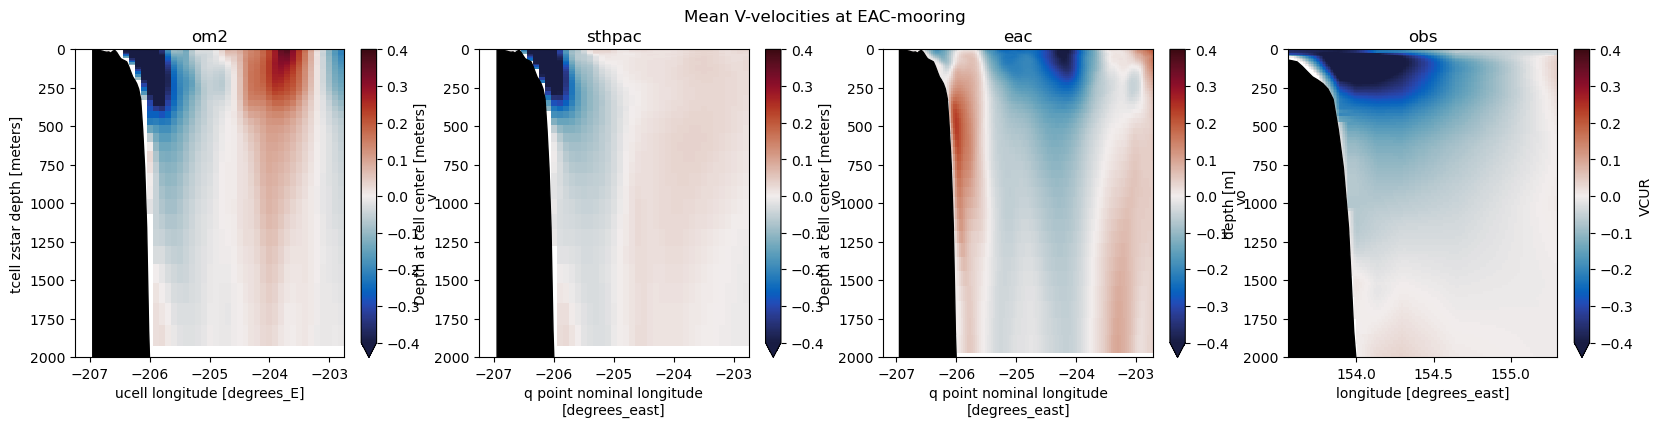

In [63]:
mean_ls = [om2_v_mean, sthpac_v_mean, eac_v_mean, obs_v_mean]
# depth_ls = [om2_depth, sthpac_depth, eac_depth, obs_depth]
model_names = ['om2', 'sthpac', 'eac', 'obs']

# proj = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
# mean velocities
for i, ax in enumerate(axes.flatten()):
    p = mean_ls[i].plot(ax=ax, cmap=cm.cm.balance, vmin=-0.4, vmax=0.4)
    if i != 3:
        ax.fill_between(eac_depthslice.xh, eac_depthslice, 5000, color='k')
    else:
        ax.fill_between(eac_depthslice.xh+360, eac_depthslice, 5000, color='k')
    ax.set_title(model_names[i])
    ax.set_ylim(2000,0)

fig.suptitle('Mean V-velocities at EAC-mooring')

Okay, so remembering this is only a preliminary result - it's quite interesting just how strong the signal is in the EAC-003. I think we actually captured quite an interesting event when selecting only the one month there. 

In [64]:
%%time
# Calculate standard-deviation
slice_ls = [om2_slice, sthpac_slice, eac_slice, obs_slice]
std_ls = []
for model in slice_ls:
    std_da = model.std(dim='time', skipna=True).load()
    std_ls.append(std_da)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


CPU times: user 3.6 s, sys: 1.32 s, total: 4.92 s
Wall time: 24.6 s


Text(0.5, 0.98, 'Std V-velocities at EAC-mooring')

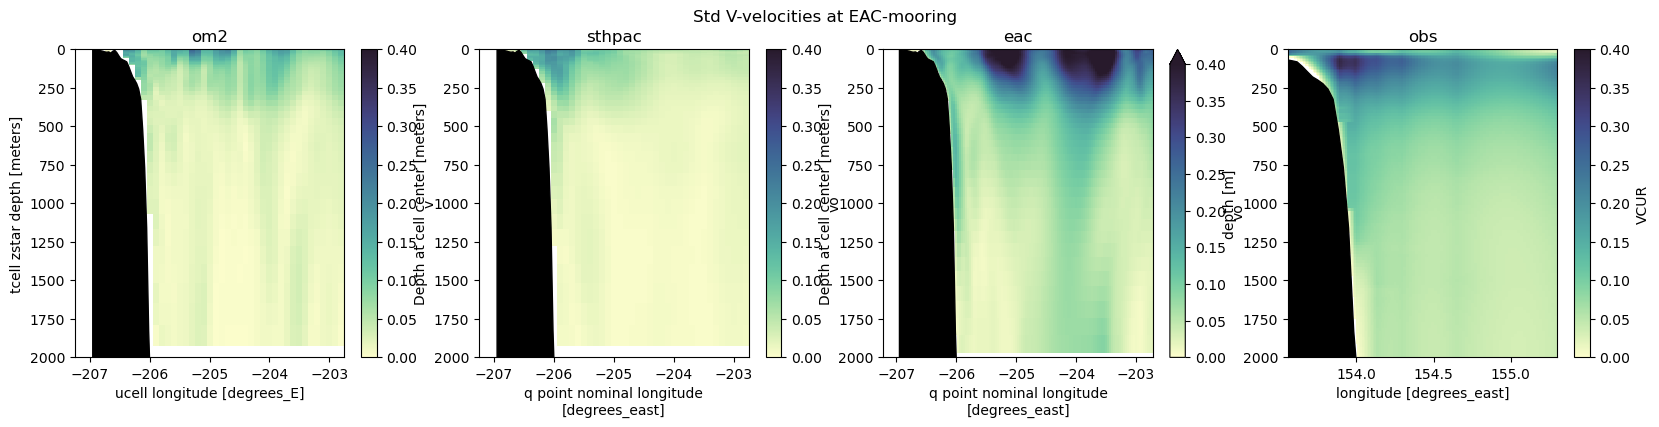

In [74]:
# depth_ls = [om2_depth, sthpac_depth, eac_depth, obs_depth]
model_names = ['om2', 'sthpac', 'eac', 'obs']

# proj = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
# mean velocities
for i, ax in enumerate(axes.flatten()):
    p = std_ls[i].plot(ax=ax, cmap=cm.cm.deep, vmin=0, vmax=0.4)
    
    if i != 3:
        ax.fill_between(eac_depthslice.xh, eac_depthslice, 5000, color='k')
        # ax.set_xlim(-207, -206)
    else:
        ax.fill_between(eac_depthslice.xh+360, eac_depthslice, 5000, color='k')
    ax.set_title(model_names[i])
    ax.set_ylim(2000,0)

fig.suptitle('Std V-velocities at EAC-mooring')

Alrighty, well this is showing some interesting and positive results. The variance for EAC is huge - I wonder if that will reduce overall when we take longer timespans?

**One More Quick Aside:** The continental shelf region looks so insignificant in these, however this is what my whole focus is really. Let's try to make a new box showing the shelf region mostly, and see how things look - I'd like to plot the vertical levels in the coastal region as a quick look at how things are. 

In [ ]:
shelf_lon = [153, 154.5]
shelf_lat = -28

I'd also like to take the PDFs - that's pretty much the last thing to do...

## PDFs of long-term mooring stations

In [ ]:
maria_coords = {'lat':-42.5970, 'lon':148.233}


Text(0.5, 1.0, 'Transect Bathymetry at EAC-Mooring site')

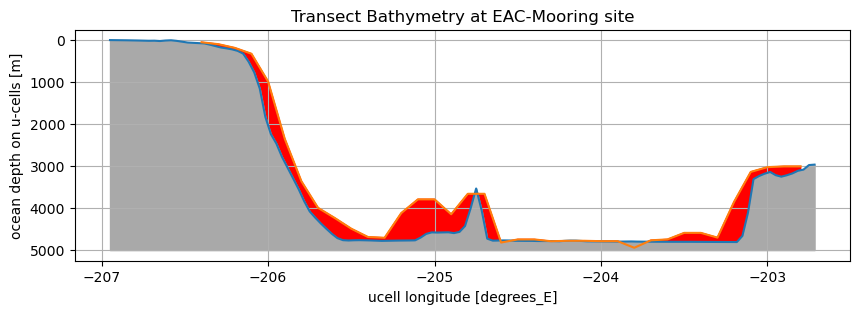

In [161]:
fig, ax = plt.subplots(figsize=(10,3))
eac_depthslice = eac_depth.sel(yh=eac_mooring['lat'], method='nearest').sel(xh=slice(closeupBox['W'], closeupBox['E']))
eac_depthslice.plot(ax=ax)
om2_depthslice.plot(ax=ax)
ax.fill_between(eac_depthslice.xh, eac_depthslice, 5000, color='darkgrey')
ax.fill_between(om2_depthslice.xu_ocean, om2_depthslice, 5000, color='red', zorder=0)
ax.grid()
plt.gca().invert_yaxis()
ax.set_title('Transect Bathymetry at EAC-Mooring site')

In [176]:
eac_slice_snap

<xarray.Dataset>
Dimensions:  (z_l: 100, time: 1, xq: 594, xh: 136, yq: 1140)
Coordinates:
    yh       float64 -27.29
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 4.946e+03 5.134e+03 5.324e+03
  * time     (time) object 1992-10-10 12:00:00
  * xq       (xq) float64 -217.8 -217.7 -217.7 -217.7 ... -198.1 -198.0 -198.0
  * xh       (xh) float64 -207.2 -207.2 -207.1 -207.1 ... -202.8 -202.7 -202.7
  * yq       (yq) float64 -46.17 -46.14 -46.12 -46.1 ... -14.12 -14.09 -14.06
Data variables:
    uo       (time, z_l, xq) float32 nan nan nan nan nan ... nan nan nan nan nan
    vo       (time, z_l, xq) float32 nan nan nan nan nan ... nan nan nan nan nan
    dxt      (xh) float32 nan nan nan nan ... 3.294e+03 3.294e+03 3.294e+03
    dyt      (xh) float32 nan nan nan nan ... 3.295e+03 3.295e+03 3.295e+03
Attributes:
    units:          m s-1
    long_name:      Sea Water X Velocity
    cell_methods:   z_l:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

In [177]:
eac_slice_snap = eac_slice_snap.sel(xq = slice(closeupBox['W'], closeupBox['E']))

In [186]:
om2_slice_snap = om2_slice_snap.squeeze()
eac_slice_snap = eac_slice_snap.squeeze()

Text(0.5, 1.0, 'EAC-003')

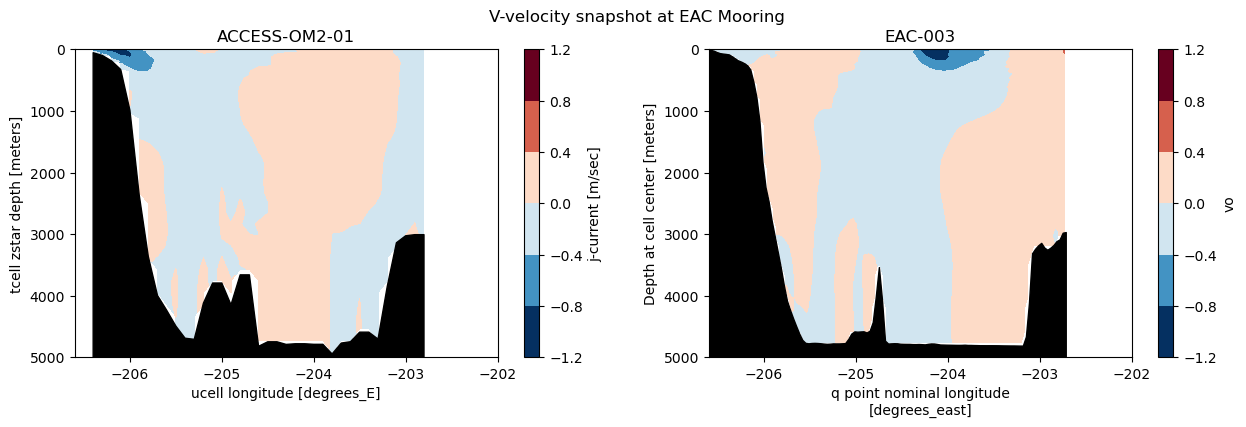

In [187]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
om2_slice_snap['v'].plot.contourf(ax=axs[0], levels=20)
axs[0].set_ylim(5000, 0)
axs[0].fill_between(om2_depthslice.xu_ocean, om2_depthslice, 5000, color='k')
axs[0].set_xlim(-206.6, -202)

eac_slice_snap['vo'].plot.contourf(ax=axs[1], levels=20)
axs[1].set_ylim(5000,0)
axs[1].fill_between(eac_depthslice.xh, eac_depthslice, 5000, color='k')
axs[1].set_xlim(-206.6, -202)

fig.suptitle('V-velocity snapshot at EAC Mooring')
axs[0].set_title('ACCESS-OM2-01')
axs[1].set_title('EAC-003')

### Density calculation example
For this we need temp,salt which we currently don't have. 

In [7]:
# Bathymetry (on tracer grid: ht, on momentum grid: hu)
ht = cc.querying.getvar(expt, 'ht', session, n=1)
# Select area of temporal high res data
ht = ht.sel(xt_ocean=slice(lon_min, lon_max)).sel(yt_ocean=slice(lat_min, lat_max))

# Temperature, convert to degree Celsius
temp = cc.querying.getvar(expt=expt, variable='temp', session=session, frequency='3 hourly', start_time=start_time, end_time=end_time) - 273.15
# temp = temp.sel(xt_ocean=slice(lon_min, lon_max)).sel(yt_ocean=slice(lat_min,lat_max))
salt = cc.querying.getvar(expt=expt, variable='salt', session=session, frequency='3 hourly', start_time=start_time, end_time=end_time)
# salt = salt.sel(xt_ocean=slice(lon_min, lon_max)).sel(yt_ocean=slice(lat_min,lat_max))

# Define Tracer latitude and longitude
lat_t = temp.yt_ocean_sub01; lon_t = temp.xt_ocean_sub01

In [33]:
temp

<xarray.DataArray 'temp' (time: 2920, st_ocean: 75, yt_ocean_sub01: 119, xt_ocean_sub01: 351)>
dask.array<sub, shape=(2920, 75, 119, 351), dtype=float32, chunksize=(1, 38, 60, 176), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean_sub01  (xt_ocean_sub01) float64 40.05 40.15 40.25 ... 74.95 75.05
  * yt_ocean_sub01  (yt_ocean_sub01) float64 -68.99 -68.94 ... -64.03 -63.98
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time            (time) object 2141-01-01 01:30:00 ... 2141-12-31 22:30:00

### Potential Density calculation:
Calculate density using the salt and temp variables. 

In [8]:
# Firstly calculate pressure from depth:
P = gsw.p_from_z(temp.st_ocean, lat_t)

# Calculate Absolute Salinity from Practical Salinity
SA = gsw.SA_from_SP(salt, P, lon_t, lat_t)

# Use Absolute Salinity and Conservative Temperature to deterine potential density
rho_p = gsw.sigma1(SA, temp)
rho_p

<xarray.DataArray (time: 2920, st_ocean: 75, yt_ocean_sub01: 119, xt_ocean_sub01: 351)>
dask.array<sigma1, shape=(2920, 75, 119, 351), dtype=float64, chunksize=(1, 38, 60, 176), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean_sub01  (xt_ocean_sub01) float64 40.05 40.15 40.25 ... 74.95 75.05
  * yt_ocean_sub01  (yt_ocean_sub01) float64 -68.99 -68.94 ... -64.03 -63.98
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time            (time) object 2141-01-01 01:30:00 ... 2141-12-31 22:30:00

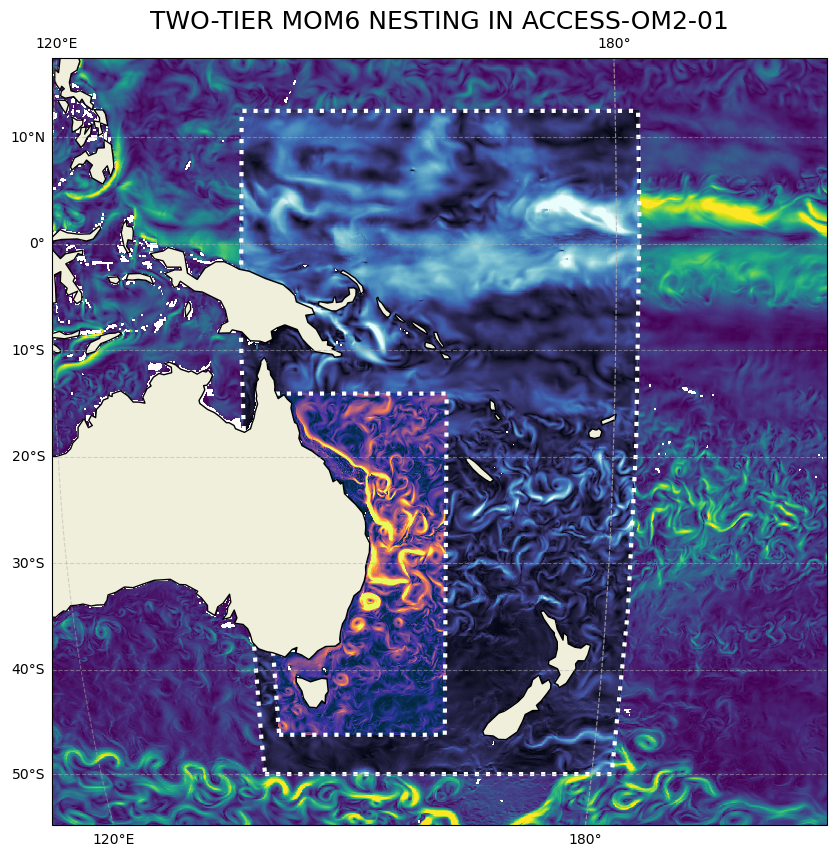

In [57]:
# create figure
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-200))

# Plot access 
om2_speed.plot(ax=ax, vmin=0, vmax=.7, transform=ccrs.PlateCarree(), zorder=0, alpha=1, add_colorbar=False)
sthpac_speed.plot(ax=ax,vmin=0, vmax=.7, transform=ccrs.PlateCarree(), cmap=cm.cm.ice, add_colorbar=False)
eac_speed.plot(ax=ax,vmin=0, vmax=.7, transform=ccrs.PlateCarree(), cmap=cm.cm.thermal, add_colorbar=False)

box1 = patches.Rectangle((sthpac_idx['W'], sthpac_idx['S']), (sthpac_idx['E']-sthpac_idx['W']), 
                        (sthpac_idx['N']-sthpac_idx['S']), color='w', fill=None, transform=ccrs.PlateCarree(),
                        alpha=1, linestyle=':', linewidth=3)
box2 = patches.Rectangle((eac_idx['W'], eac_idx['S']), (eac_idx['E']-eac_idx['W']), 
                        (eac_idx['N']-eac_idx['S']), color='w', fill=None, transform=ccrs.PlateCarree(),
                        alpha=1, linestyle=':', linewidth=3)

ax.add_patch(box1); ax.add_patch(box2)

ax.add_feature(cfeature.LAND, zorder=0)

ax.add_feature(cfeature.LAND, zorder=1)
# ax.gridlines()

extent = [sthpac_idx['W']-20, sthpac_idx['E']+20, sthpac_idx['S']-5, sthpac_idx['N']+5]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.coastlines()

ax.set_title('TWO-TIER MOM6 NESTING IN ACCESS-OM2-01', fontsize=18)

# Set custom ticks on x and y axes
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree());

# # Add latitude and longitude labels to the ticks
# lon_formatter = LongitudeFormatter(zero_direction_label=True)
# lat_formatter = LatitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)

ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')

fig.savefig('/home/581/jr5971/jr5971/notebooks/figures/nesting_overview_3cmap_wt-gridlines.png')

In [66]:
eac_2d_snap_latlon = eac_2d_snap.rename({'xq':'lon', 'yh':'lat'})
eac_2d_snap_latlon

<xarray.Dataset>
Dimensions:  (lat: 1140, time: 1, lon: 594, xh: 594, yq: 1140)
Coordinates:
  * lat      (lat) float64 -46.18 -46.16 -46.13 -46.11 ... -14.14 -14.11 -14.07
    z_l      float64 4.673
  * time     (time) object 1992-10-10 12:00:00
  * lon      (lon) float64 -217.8 -217.7 -217.7 -217.7 ... -198.1 -198.0 -198.0
  * xh       (xh) float64 -217.8 -217.7 -217.7 -217.7 ... -198.1 -198.0 -198.0
  * yq       (yq) float64 -46.17 -46.14 -46.12 -46.1 ... -14.12 -14.09 -14.06
Data variables:
    uo       (time, lat, lon) float32 -0.02677 -0.005465 ... -0.2489 -0.2552
    vo       (time, lat, lon) float32 nan nan nan nan ... -0.05078 -0.04243 nan
    dxt      (lat, xh) float32 ...
    dyt      (lat, xh) float32 ...
Attributes:
    units:          m s-1
    long_name:      Sea Water X Velocity
    cell_methods:   z_l:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

### Using xgcm
Now we're going to regrid to hopefully make things easier for plotting the streamplots

In [59]:
def regrid_for_streamplot(u, v, res):
    # Create target grid that has equal spaced points (a requirement for streamplot)
    x_target = np.linspace(u['lon'].min(), u['lon'].max(), int(len(u['lon']) / res))
    y_target = np.linspace(u['lat'].min(), u['lat'].max(), int(len(u['lat']) / res))
    X_target, Y_target = np.meshgrid(x_target, y_target)
    
    # Create regridder object
    regridder = xesmf.Regridder(u, {'lon':X_target, 'lat':Y_target}, 'bilinear')
    
    # regrid data
    u_target = regridder(u)
    v_target = regridder(v)
    
    return x_target, y_target, u_target, v_target

In [69]:
%%time
x, y, u, v = regrid_for_streamplot(u=eac_2d_snap_latlon['uo'], v=eac_2d_snap_latlon['vo'], res=2)

CPU times: user 12.3 s, sys: 843 ms, total: 13.1 s
Wall time: 11.3 s


In [70]:
u = u.squeeze()
v = v.squeeze()

CPU times: user 6.67 s, sys: 145 ms, total: 6.82 s
Wall time: 6.2 s


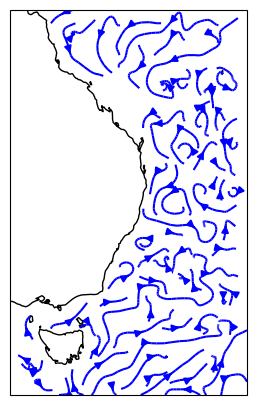

In [124]:
%%time
plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2))
ax.set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())
ax.streamplot(x, y, u, v, density=1, color='b', transform=ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND, color='green')
ax.coastlines()

#### Combine the streamlines with the bathymetry

In [71]:
om2_bath = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output120/ocean/ocean-2d-ht.nc')['ht']
om2_bath_sub = om2_bath.sel(xt_ocean=slice(smokey_box['W'], smokey_box['E']), yt_ocean=slice(smokey_box['S'], smokey_box['N'])).squeeze()
om2_bath_sub

<xarray.DataArray 'ht' (yt_ocean: 54, xt_ocean: 30)>
[1620 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -213.5 -213.4 -213.3 ... -210.8 -210.7 -210.6
  * yt_ocean  (yt_ocean) float64 -45.04 -44.97 -44.89 ... -41.32 -41.24 -41.17
Attributes:
    long_name:      ocean depth on t-cells
    units:          m
    valid_range:    [-1.e+09  1.e+09]
    cell_methods:   time: point
    coordinates:    geolon_t geolat_t
    standard_name:  sea_floor_depth_below_geoid

In [72]:
om2_2d_snap_latlon = om2_2d_snap.rename({'xu_ocean':'lon', 'yu_ocean':'lat'}).sel(lon=slice(smokey_box['W'], smokey_box['E']), lat=slice(smokey_box['S'], smokey_box['N']))
om2_2d_snap_latlon = om2_2d_snap_latlon.chunk({'lon':-1, 'lat':-1})

In [73]:
x_om, y_om, u_om, v_om = regrid_for_streamplot(u=om2_2d_snap_latlon['u'], v=om2_2d_snap_latlon['v'], res=2)
u_om = u_om.squeeze()
v_om = v_om.squeeze()

CPU times: user 844 ms, sys: 86 ms, total: 930 ms
Wall time: 3.33 s


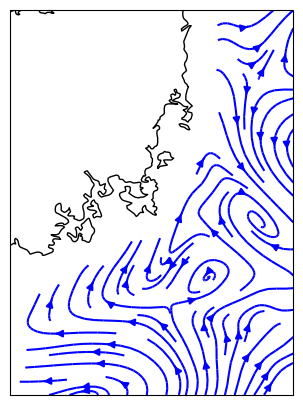

In [39]:
%%time
plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2))
ax.set_extent([x_om.min(), x_om.max(), y_om.min(), y_om.max()], crs=ccrs.PlateCarree())
ax.streamplot(x_om, y_om, u_om, v_om, density=1, color='b', transform=ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND, color='green')
ax.coastlines()

In [37]:
smokey_depth

<xarray.DataArray 'deptho' (yh: 164, xh: 90)>
[14760 values with dtype=float32]
Coordinates:
  * xh       (xh) float64 -213.5 -213.5 -213.5 -213.4 ... -210.6 -210.6 -210.6
  * yh       (yh) float64 -45.08 -45.06 -45.04 -45.01 ... -41.17 -41.14 -41.12
Attributes:
    units:          m
    long_name:      Sea Floor Depth
    cell_methods:   area:mean yh:mean xh:mean time: point
    cell_measures:  area: areacello
    standard_name:  sea_floor_depth_below_geoid

Text(0.5, 0.98, 'SE-TAS Velocity Daily snapshot')

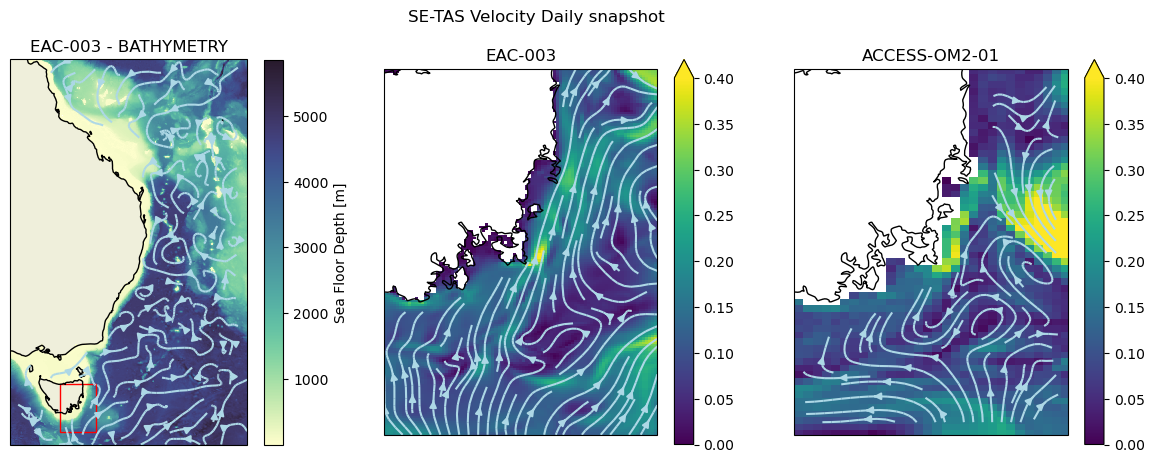

In [79]:
smokey_depth = eac_depth.sel(xh=slice(smokey_box['W'], smokey_box['E']), yh=slice(smokey_box['S'], smokey_box['N']))

fig, axes = plt.subplots(1,3, figsize=(15,5), subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2)))
eac_depth.plot(ax=axes[0], cmap=cm.cm.deep, transform=ccrs.PlateCarree())
axes[0].set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())
axes[0].streamplot(x, y, u, v, density=1, color='lightblue', transform=ccrs.PlateCarree())
axes[0].add_feature(cfeature.LAND)
axes[0].coastlines()
box_sc = patches.Rectangle((smokey_box['W'], smokey_box['S']), (smokey_box['E']-smokey_box['W']),
                           (smokey_box['N']-smokey_box['S']), color='r', fill=None, transform=ccrs.PlateCarree())
axes[0].add_patch(box_sc)
axes[0].set_title('EAC-003 - BATHYMETRY')
eac_speed.plot(ax=axes[1], vmin=0, vmax=.4, transform=ccrs.PlateCarree())
axes[1].set_extent([smokey_depth.xh.min(), smokey_depth.xh.max(), smokey_depth.yh.min(), smokey_depth.yh.max()], crs=ccrs.PlateCarree())
axes[1].streamplot(x, y, u, v, density=1, color='lightblue', transform=ccrs.PlateCarree())
axes[1].scatter(smokey_cape[0], smokey_cape[1], color='grey', marker='o', s=10)
# axes[1].add_feature(cfeature.LAND)
axes[1].coastlines()
axes[1].set_title('EAC-003')

om2_speed.plot(ax=axes[2], vmin=0, vmax=.4, transform=ccrs.PlateCarree())
axes[2].set_extent([smokey_depth.xh.min(), smokey_depth.xh.max(), smokey_depth.yh.min(), smokey_depth.yh.max()], crs=ccrs.PlateCarree())
axes[2].streamplot(x_om, y_om, u_om, v_om, density=1, color='lightblue', transform=ccrs.PlateCarree())
# axes[2].add_feature(cfeature.LAND)
axes[2].coastlines()
axes[2].set_title('ACCESS-OM2-01')

fig.suptitle('SE-TAS Velocity Daily snapshot')

Text(0.5, 0.98, 'SE-TAS Velocity Daily snapshot')

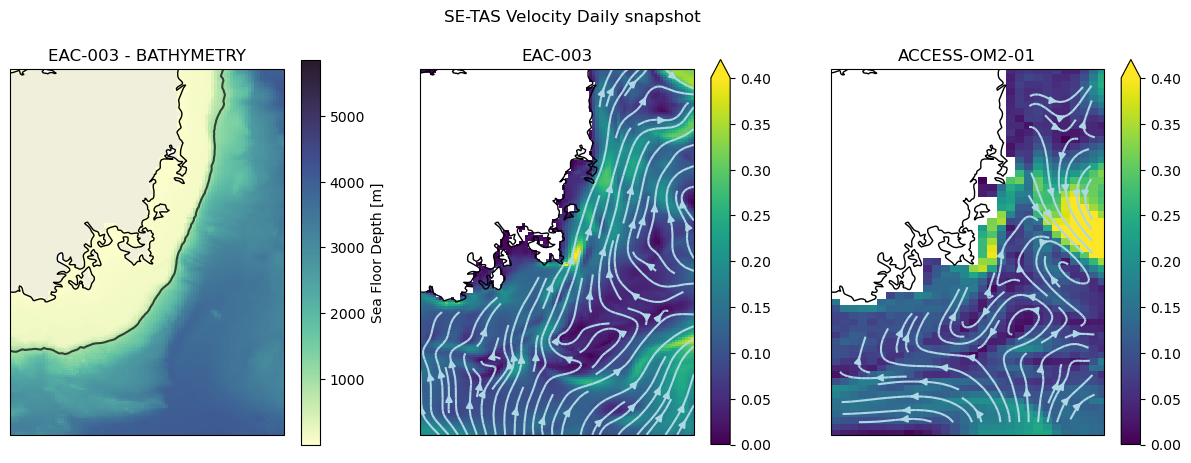

In [88]:
smokey_depth = eac_depth.sel(xh=slice(smokey_box['W'], smokey_box['E']), yh=slice(smokey_box['S'], smokey_box['N']))

fig, axes = plt.subplots(1,3, figsize=(15,5), subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2)))
eac_depth.plot(ax=axes[0], cmap=cm.cm.deep, transform=ccrs.PlateCarree())
# axes[0].set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())
axes[0].set_extent([smokey_depth.xh.min(), smokey_depth.xh.max(), smokey_depth.yh.min(), smokey_depth.yh.max()], crs=ccrs.PlateCarree())
c1 = eac_depth.plot.contour(ax=axes[0], levels=[1000], colors='k', transform=ccrs.PlateCarree(), alpha=0.7)
axes[0].clabel(c1, inline=1, fontsize=5)
# axes[0].streamplot(x, y, u, v, density=1, color='lightblue', transform=ccrs.PlateCarree())
axes[0].add_feature(cfeature.LAND)
axes[0].coastlines()
box_sc = patches.Rectangle((smokey_box['W'], smokey_box['S']), (smokey_box['E']-smokey_box['W']),
                           (smokey_box['N']-smokey_box['S']), color='r', fill=None, transform=ccrs.PlateCarree())
axes[0].add_patch(box_sc)
axes[0].set_title('EAC-003 - BATHYMETRY')
eac_speed.plot(ax=axes[1], vmin=0, vmax=.4, transform=ccrs.PlateCarree())
axes[1].set_extent([smokey_depth.xh.min(), smokey_depth.xh.max(), smokey_depth.yh.min(), smokey_depth.yh.max()], crs=ccrs.PlateCarree())
axes[1].streamplot(x, y, u, v, density=1, color='lightblue', transform=ccrs.PlateCarree())
axes[1].scatter(smokey_cape[0], smokey_cape[1], color='grey', marker='o', s=10)
# axes[1].add_feature(cfeature.LAND)
axes[1].coastlines()
axes[1].set_title('EAC-003')

om2_speed.plot(ax=axes[2], vmin=0, vmax=.4, transform=ccrs.PlateCarree())
axes[2].set_extent([smokey_depth.xh.min(), smokey_depth.xh.max(), smokey_depth.yh.min(), smokey_depth.yh.max()], crs=ccrs.PlateCarree())
axes[2].streamplot(x_om, y_om, u_om, v_om, density=1, color='lightblue', transform=ccrs.PlateCarree())
# axes[2].add_feature(cfeature.LAND)
axes[2].coastlines()
axes[2].set_title('ACCESS-OM2-01')

fig.suptitle('SE-TAS Velocity Daily snapshot')

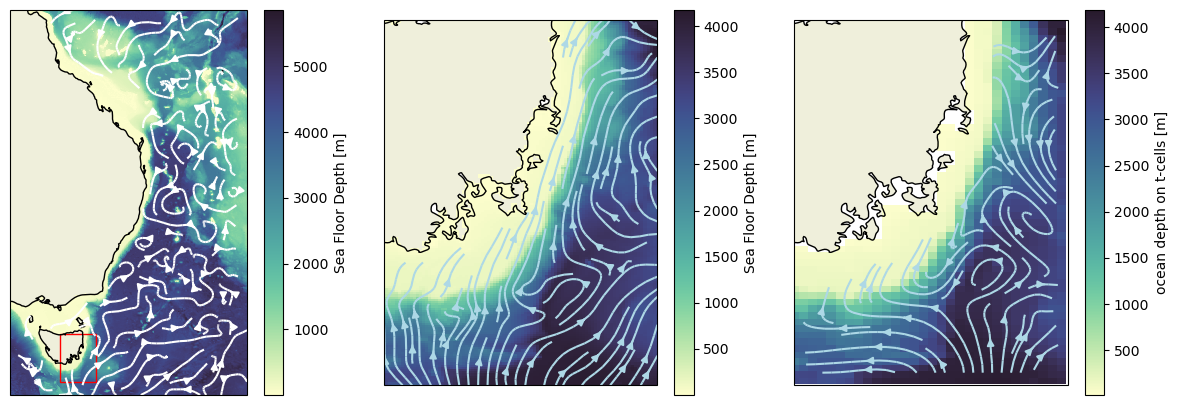

In [38]:
smokey_depth = eac_depth.sel(xh=slice(smokey_box['W'], smokey_box['E']), yh=slice(smokey_box['S'], smokey_box['N']))

fig, axes = plt.subplots(1,3, figsize=(15,5), subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2)))
eac_depth.plot(ax=axes[0], cmap=cm.cm.deep, transform=ccrs.PlateCarree())
axes[0].set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())
axes[0].streamplot(x, y, u, v, density=1, color='w', transform=ccrs.PlateCarree())
axes[0].add_feature(cfeature.LAND)
axes[0].coastlines()
box_sc = patches.Rectangle((smokey_box['W'], smokey_box['S']), (smokey_box['E']-smokey_box['W']),
                           (smokey_box['N']-smokey_box['S']), color='r', fill=None, transform=ccrs.PlateCarree())
axes[0].add_patch(box_sc)
smokey_depth.plot(ax=axes[1], cmap=cm.cm.deep, transform=ccrs.PlateCarree())
axes[1].set_extent([smokey_depth.xh.min(), smokey_depth.xh.max(), smokey_depth.yh.min(), smokey_depth.yh.max()], crs=ccrs.PlateCarree())
axes[1].streamplot(x, y, u, v, density=1, color='lightblue', transform=ccrs.PlateCarree())
axes[1].scatter(smokey_cape[0], smokey_cape[1], color='grey', marker='o', s=10)
axes[1].add_feature(cfeature.LAND)
axes[1].coastlines()

om2_bath_sub.plot(ax=axes[2], cmap=cm.cm.deep, transform=ccrs.PlateCarree())
axes[2].set_extent([smokey_depth.xh.min(), smokey_depth.xh.max(), smokey_depth.yh.min(), smokey_depth.yh.max()], crs=ccrs.PlateCarree())
axes[2].streamplot(x_om, y_om, u_om, v_om, density=1, color='lightblue', transform=ccrs.PlateCarree())
axes[2].add_feature(cfeature.LAND)
axes[2].coastlines()

